# AI Tools for Actuaries
## Chapter 5: FNN entity embedding
### Author: Michael Mayer and Mario Wuthrich
### Version April, 2025

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf  
from tensorflow import keras

# See all pandas columns
pd.set_option("display.max_columns", None)

# Helps to keep results reproducible
tf.config.experimental.enable_op_determinism()

## Load data and build Learn-Test split

In [2]:
df = pd.read_parquet("../../Data/freMTPL2freq.parquet")
df.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678007 non-null  float64 
 1   Exposure    678007 non-null  float64 
 2   Area        678007 non-null  category
 3   VehPower    678007 non-null  int32   
 4   VehAge      678007 non-null  int32   
 5   DrivAge     678007 non-null  int32   
 6   BonusMalus  678007 non-null  int32   
 7   VehBrand    678007 non-null  category
 8   VehGas      678007 non-null  category
 9   Density     678007 non-null  int32   
 10  Region      678007 non-null  category
 11  ClaimTotal  678007 non-null  float64 
 12  ClaimNb     678007 non-null  float64 
 13  LearnTest   678007 non-null  object  
dtypes: category(4), float64(4), int32(5), object(1)
memory usage: 41.4+ MB
None


In [4]:
learn = df[df["LearnTest"] == "L"]
test = df[df["LearnTest"] == "T"]

## Pre-process data for FNN - for entity embedding and standardization
### Define the Scikit-Learn preprocessor

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler,
)


def clip_and_scale(upper):
    pipe = Pipeline(
        steps=[
            ("clip", FunctionTransformer(lambda x: np.clip(x, a_min=0, a_max=upper))),
            ("scale", StandardScaler()),
        ]
    )
    return pipe


density = Pipeline(
    steps=[
        ("log", FunctionTransformer(lambda x: np.log(x).round(2))),
        ("scale", StandardScaler()),
    ]
)

area = Pipeline(
    steps=[
        ("encode", OrdinalEncoder()),
        ("scale", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            "scale",
            clip_and_scale([20, 90, 150, 15]),
            ["VehAge", "DrivAge", "BonusMalus", "VehPower"],
        ),
        ("area", area, ["Area"]),
        ("density", density, ["Density"]),
        ("veh_gas", FunctionTransformer(lambda x: x == "Diesel"), ["VehGas"]),
        ("veh_brand", OrdinalEncoder(), ["VehBrand", "Region"]),
    ],
    verbose_feature_names_out=False,
)

# Just a check: Fit preprocessor to training data and apply to some lines from test
preprocessor.set_output(transform="pandas").fit(learn)
preprocessor.transform(test.head())

,VehAge,DrivAge,BonusMalus,VehPower,Area,Density,VehGas,VehBrand,Region
610206,-1.29173,-1.309026,1.937902,-1.196789,0.513423,0.298236,False,3.0,14.0
610207,-1.29173,-0.884378,2.578711,-0.709264,0.513423,0.795155,False,3.0,0.0
610208,-1.29173,-0.884378,2.578711,-0.709264,0.513423,0.795155,False,3.0,0.0
610209,-1.29173,1.663510,-0.497176,-0.709264,0.513423,0.666918,False,3.0,0.0
610210,-1.29173,0.460341,-0.625338,-0.709264,-0.209473,-0.476529,False,3.0,20.0


### Split in covariates X, responses y, exposures v


In [6]:
X_learn = preprocessor.fit_transform(learn)
X_test = preprocessor.transform(test)

y_learn, v_learn = learn.ClaimNb, learn.Exposure
y_test, v_test = test.ClaimNb, test.Exposure

## FNN entity embedding encoded categorical features

In [7]:
# define FNN with entity embedding and three hidden layers
def create_fnn(seed, n_features, hidden_layers, kk, bb, freeze_hidden=False):
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(seed)

    design_input = keras.layers.Input(shape=(n_features,))
    volume_input = keras.layers.Input(shape=(1,))
    
    # Extract brand and region features (last two columns)
    brand_input = keras.layers.Lambda(lambda x: x[:, -2:-1])(design_input)
    region_input = keras.layers.Lambda(lambda x: x[:, -1:])(design_input)
    
    # Embedding layers
    brand_embed = keras.layers.Embedding(input_dim=kk[0], output_dim=bb[0], input_length=1, trainable=not freeze_hidden)(brand_input)
    brand_embed = keras.layers.Flatten()(brand_embed)
    
    region_embed = keras.layers.Embedding(input_dim=kk[1], output_dim=bb[1], input_length=1, trainable=not freeze_hidden)(region_input)
    region_embed = keras.layers.Flatten()(region_embed)
    
    # Continuous features (all except last two columns)
    continuous_features = keras.layers.Lambda(lambda x: x[:, :-2])(design_input)
    
    # Concatenate all features
    x = keras.layers.Concatenate()([continuous_features, brand_embed, region_embed])
    
    # build the network
    for q in hidden_layers:
        x = keras.layers.Dense(q, activation="tanh", trainable=not freeze_hidden)(x)
    x = keras.layers.Dense(1, activation="exponential")(x)

    output = keras.layers.Multiply()([x, volume_input])

    model = keras.Model(inputs=[design_input, volume_input], outputs=output)

    return model


In [9]:

SEED = 1234
HIDDEN = [20, 15, 10]
M_FEAT = X_learn.shape[1]
KK = [len(learn['VehBrand'].unique()), len(learn['Region'].unique())]
BB  = [2,2]


# Create model with three hidden layers
model = create_fnn(SEED, M_FEAT, HIDDEN, KK, BB)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 2)      │         22 │ lambda[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 2)      │         44 │ lambda_1[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 7)         │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 11)        │          0 │ lambda_2[0][0],   │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │        240 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 15)        │        315 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         11 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1)         │          0 │ dense_3[0][0],    │
│                     │                   │            │ input_layer_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 792 (3.09 KB)

 Trainable params: 792 (3.09 KB)

 Non-trainable params: 0 (0.00 B)

## Homogeneous case not considering any covariates

In [10]:

from sklearn.metrics import mean_poisson_deviance

mu_hom = learn.ClaimNb.sum() / learn.Exposure.sum()  # homogeneous frequency
w0 = model.get_weights()
w0[-2] *= 0
w0[-1][0] = np.log(mu_hom)
model.set_weights(w0)


# Helper functions to evaluate the model via total Poisson deviance
def score(model, X, y, v):
    """Evaluate the model using sklearn's mean_poisson_deviance."""
    pred = model.predict([X, v], batch_size=int(1e6), verbose=0).flatten()
    return 100*mean_poisson_deviance(y/v, pred/v, sample_weight=v)


print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test):.3f}")

Poisson Deviance (Learn): 47.722
Poisson Deviance (Test): 47.967


## Train the model

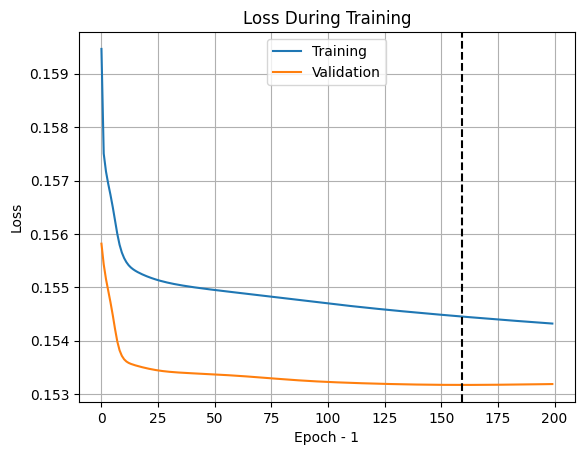

In [11]:
# Callback for saving model and for implicit early stopping (~after 60-70 epochs here)
if not os.path.exists("./Networks"):
    os.makedirs("./Networks")

checkpoint_path = f"./Networks/FNN2_emb_{SEED}.weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=True
)

# Compile model
model.compile(loss="poisson", optimizer="nadam")

# Train model
history = model.fit(
    [X_learn, v_learn],
    y_learn,
    validation_split=0.1,
    batch_size=5000,
    epochs=200,
    verbose=0,
    callbacks=[checkpoint],
)

# Plot training history (vertical line at best validation loss)
fig = (
    pd.DataFrame(history.history)
    .rename(columns={"loss": "Training", "val_loss": "Validation"})
    .plot(xlabel="Epoch - 1", ylabel="Loss", title="Loss During Training", grid=True)
)
_ = fig.axvline(
    np.argmin(model.history.history["val_loss"]), color="black", linestyle="--"
)


## Evaluate Results

In [12]:
# Load best weights and evaluate
model.load_weights(checkpoint_path)
w2 = model.get_weights()

print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test):.3f}")

learn_nn = model.predict([X_learn, v_learn], batch_size=int(1e6), verbose=0).flatten()

print(f"Balance Property: {mu_hom:.4f} {learn_nn.sum() / learn['Exposure'].sum():.4f}")

Poisson Deviance (Learn): 44.816
Poisson Deviance (Test): 44.902
Balance Property: 0.0736 0.0715


## Balance Property Adjustment

In [14]:
# Create model that has only a trainable output layer
model = create_fnn(SEED, M_FEAT, HIDDEN, KK, BB, freeze_hidden=True)
model.set_weights(w2)

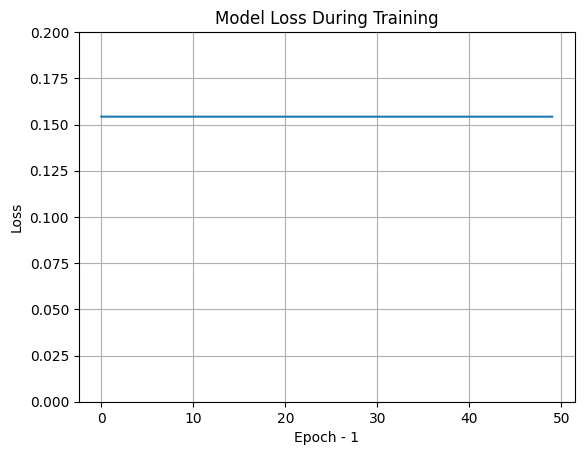

In [15]:
# Compile model
model.compile(loss="poisson", optimizer=keras.optimizers.Nadam(learning_rate=0.01))

# Train model (note that we train a Poisson model with canonical link)
history = model.fit(
    [X_learn, v_learn],
    y_learn,
    validation_split=0,
    batch_size=len(y_learn),
    epochs=50,
    verbose=0,
)

_ = pd.DataFrame(history.history).plot(
    xlabel="Epoch - 1",
    ylabel="Loss",
    title="Model Loss During Training",
    grid=True,
    legend=False,
    ylim=(0, 0.2),
)

In [17]:
print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test):.3f}")

learn_nn_reg = model.predict(
    [X_learn, v_learn], batch_size=int(1e6), verbose=0
).flatten()

print(
    f"Balance Property: {mu_hom:.4f} {learn_nn_reg.sum() / learn['Exposure'].sum():.4f}"
)

Poisson Deviance (Learn): 44.807
Poisson Deviance (Test): 44.905
Balance Property: 0.0736 0.0736


In [18]:
# save the model
path2 = f'./Networks/FNN2_emb_reg_{SEED}.weights.h5'
model.save_weights(path2)

## Visualize Embeddings

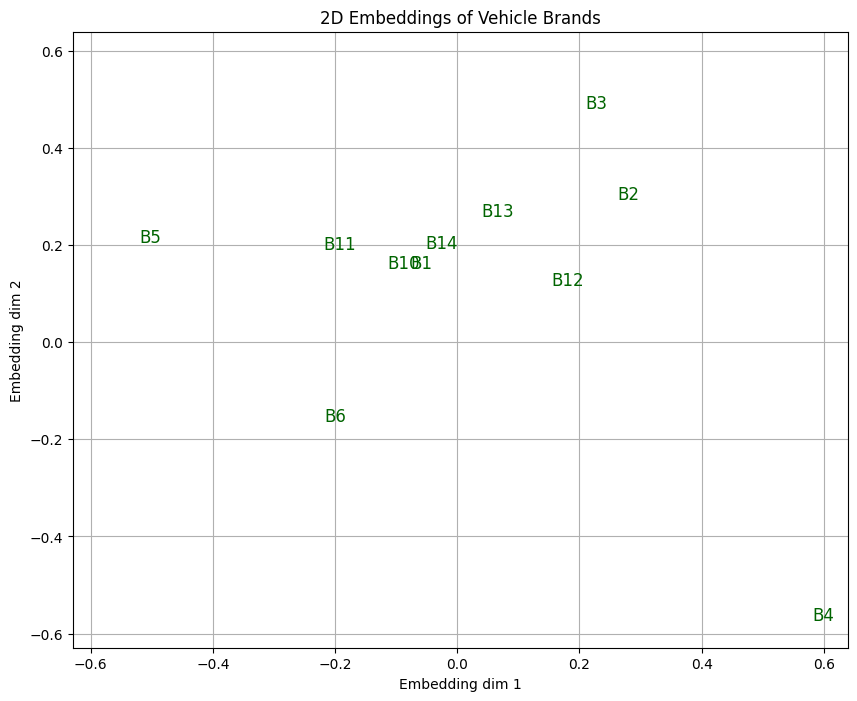

In [19]:
# Embeddings visualization
import matplotlib.pyplot as plt
w1 = model.get_weights()

# Extract embeddings
veh_br = w1[0]  

# Get unique vehicle brands and their indices
vb_names = learn.loc[~learn['VehBrand'].duplicated(), ['VehBrand']]
vb_names = vb_names.sort_values('VehBrand')

# Calculate plot limits
lim0 = 1.1 * np.array([veh_br.min(), veh_br.max()])

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(veh_br[:, 0], veh_br[:, 1], alpha=0)  # invisible points to set the scale
plt.xlim(lim0)
plt.ylim(lim0)

# Add text labels for each brand
for i, brand in enumerate(vb_names['VehBrand']):
    plt.annotate(brand, (veh_br[i, 0], veh_br[i, 1]), 
                color='darkgreen', fontsize=12)

plt.xlabel('Embedding dim 1')
plt.ylabel('Embedding dim 2')
plt.title('2D Embeddings of Vehicle Brands')
plt.grid(True)
plt.show()

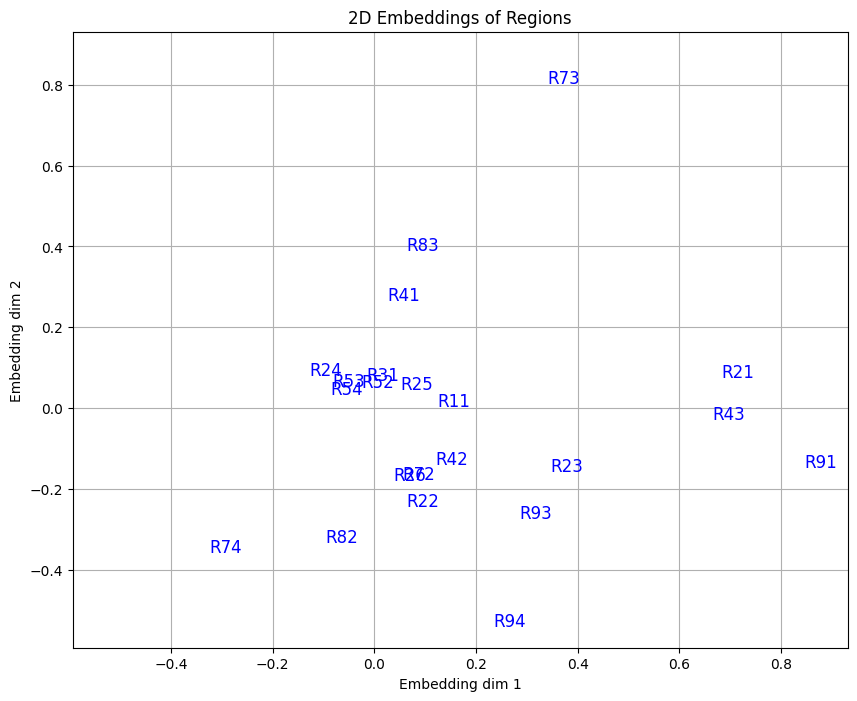

In [20]:
# Extract embeddings for regions
region_br = w1[1]  

# Get unique regions and their indices
region_names = learn.loc[~learn['Region'].duplicated(), ['Region']]
region_names = region_names.sort_values('Region')

# Calculate plot limits
lim0 = 1.1 * np.array([region_br.min(), region_br.max()])

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(region_br[:, 0], region_br[:, 1], alpha=0)  # invisible points to set the scale
plt.xlim(lim0)
plt.ylim(lim0)

# Add text labels for each region
for i, region in enumerate(region_names['Region']):
    plt.annotate(region, (region_br[i, 0], region_br[i, 1]), 
                color='blue', fontsize=12)

plt.xlabel('Embedding dim 1')
plt.ylabel('Embedding dim 2')
plt.title('2D Embeddings of Regions')
plt.grid(True)
plt.show()